In [6]:
import numpy as np
import scipy.interpolate as spi
from scipy.stats import norm
from scipy.interpolate import CubicSpline
from scipy.interpolate import Akima1DInterpolator

In [7]:
# --- Function to calculate hybrid CDF and PDF ---
def compute_cdf_pdf_interpolators(quantiles, probabilities, y_min=-30, y_max=30):
    """
    Returns interpolation functions for CDF and PDF using linear, PCHIP, and hybrid methods.

    Parameters:
    - quantiles: Array of quantiles.
    - probabilities: Array of associated probabilities for the quantiles.
    - y_min: Minimum x value for extrapolation.
    - y_max: Maximum x value for extrapolation.

    Returns:
    - cdf_linear(x): Linear interpolation CDF function.
    - cdf_pchip(x): PCHIP interpolation CDF function.
    - hybrid_cdf(x): Hybrid CDF (PCHIP + normal tails).
    - pdf_linear(x): Linear interpolation PDF function.
    - pdf_pchip(x): PCHIP derivative PDF function.
    - pdf_hybrid(x): Hybrid PDF (PCHIP + normal tails).
    """

    # Extend quantile and probability arrays
    full_quantiles = np.concatenate(([y_min], quantiles, [y_max]))
    full_probabilities = np.concatenate(([0], probabilities, [1]))

    # --- Calculate minimum difference between consecutive quantiles ---
    delta_quantiles = np.diff(quantiles)
    min_delta_quantile = np.min(delta_quantiles)


    # --- Fit Normal Distributions for Tails ---
    def fit_tail_distribution(quantiles, probabilities):
        """Fits a normal distribution to the given quantiles and associated probabilities."""
        z_scores = norm.ppf(probabilities)
        sigma = (quantiles[1] - quantiles[0]) / (z_scores[1] - z_scores[0])
        mu = quantiles[0] - sigma * z_scores[0]
        return mu, sigma

    # Fit left and right tails
    mu_left, sigma_left = fit_tail_distribution(quantiles[:2], probabilities[:2])
    mu_right, sigma_right = fit_tail_distribution(quantiles[-2:], probabilities[-2:])

    # --- Define CDF Interpolators ---
    cdf_linear_interpolator = spi.interp1d(
        full_quantiles, full_probabilities, kind="linear", fill_value=(0, 1), bounds_error=False
    )
    #cdf_pchip_interpolator = spi.PchipInterpolator(full_quantiles, full_probabilities, extrapolate=True)
    #cdf_pchip_interpolator = spi.interp1d(quantiles, probabilities, kind='quadratic', fill_value=(0, 1), bounds_error=False)
    cdf_pchip_interpolator = spi.Akima1DInterpolator(full_quantiles, full_probabilities)


    def cdf_linear(x):
        """Linear interpolation CDF function."""
        return float(np.clip(cdf_linear_interpolator(x), 0, 1))

    def cdf_pchip(x):
        """PCHIP interpolation CDF function."""
        return float(np.clip(cdf_pchip_interpolator(x), 0, 1))

    def hybrid_cdf(x):
        """
        Hybrid CDF:
        - Left normal fit for x < first quantile
        - PCHIP interpolation for middle range
        - Right normal fit for x > last quantile
        """
        if x < quantiles[0]:  # Left tail
            return norm.cdf(x, loc=mu_left, scale=sigma_left)
        elif x > quantiles[-1]:  # Right tail
            return norm.cdf(x, loc=mu_right, scale=sigma_right)
        else:  # Middle range (PCHIP interpolation)
            return float(np.clip(cdf_pchip_interpolator(x), 0, 1))

    # --- Define PDF functions (derivatives of CDFs) ---
    def pdf_linear(x):
        """Approximates PDF using finite differences of the linear CDF."""
        #eps = eps  # Small step for numerical differentiation
        eps = 0.01
        return (cdf_linear(x + eps) - cdf_linear(x - eps)) / (2 * eps)

    def pdf_linear2(x):
        """Approximates PDF using finite differences of the linear CDF."""
        eps = min_delta_quantile/2
        return (cdf_linear(x + eps) - cdf_linear(x - eps)) / (2 * eps)
    
    def pdf_pchip(x):
        """Approximates PDF using finite differences on the cubic interpolation CDF."""
        eps = min_delta_quantile/2

        return (cdf_pchip_interpolator(x + eps) - cdf_pchip_interpolator(x - eps)) / (2 * eps)
        #return cdf_pchip_interpolator.derivative()(x)

    def pdf_hybrid(x):
        """
        Hybrid PDF:
        - Left normal distribution for x < first quantile
        - PCHIP interpolation derivative for middle range
        - Right normal distribution for x > last quantile
        """
        if x < quantiles[0]:  # Left tail
            return norm.pdf(x, loc=mu_left, scale=sigma_left)
        elif x > quantiles[-1]:  # Right tail
            return norm.pdf(x, loc=mu_right, scale=sigma_right)
        else:  # Middle range (PCHIP interpolation)
            return cdf_pchip_interpolator.derivative()(x)

    return cdf_linear, cdf_pchip, hybrid_cdf, pdf_linear, pdf_linear2, pdf_pchip, pdf_hybrid


In [8]:
from scipy.stats import norm
from scipy.optimize import curve_fit
import numpy as np

# Define a function that maps probabilities to normal quantiles
def normal_cdf_inverse(p, mu, sigma):
    return norm.ppf(p, loc=mu, scale=sigma)

def fit_normal_dist_to_quantiles(probabilities, quantiles):
    """ Fits a normal distribution to given quantiles and probabilities. """
    probabilities = np.asarray(probabilities)
    quantiles = np.asarray(quantiles)
    
    # Debugging: Print inputs
    print("Probabilities:", probabilities)
    print("Quantiles:", quantiles)
    
    # Ensure valid inputs
    if np.any(np.isnan(probabilities)) or np.any(np.isnan(quantiles)):
        raise ValueError("Input contains NaN values!")
    
    if np.any(np.isinf(probabilities)) or np.any(np.isinf(quantiles)):
        raise ValueError("Input contains Inf values!")

    # Check if probabilities are within (0,1)
    if np.any(probabilities <= 0) or np.any(probabilities >= 1):
        raise ValueError("Probabilities must be between 0 and 1 (exclusive).")

    # Provide a reasonable initial guess
    mu_init = np.mean(quantiles)
    sigma_init = (np.max(quantiles) - np.min(quantiles)) / 4  # Rough estimate

    try:
        params, _ = curve_fit(normal_cdf_inverse, probabilities, quantiles, p0=[mu_init, sigma_init])
    except RuntimeError as e:
        print("Curve fitting failed:", e)
        return None, None

    mu_fit, sigma_fit = params
    print(f"Estimated Mean: {mu_fit}, Estimated Std Dev: {sigma_fit}")
    
    return mu_fit, sigma_fit

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_cdf_pdf_dynamic(quantiles, probabilities, y_min, y_max, log_scale=True, eps=0.01, case=1):
    """Plots the CDF and PDF for linear, Akima1DInterpolator, and hybrid interpolation methods."""

    # Generate x values for plotting
    x_values = np.linspace(y_min - 1, y_max + 1, 200)

    # Get CDF and PDF functions
    cdf_linear, cdf_pchip, hybrid_cdf, pdf_linear, pdf_linear2, pdf_pchip, pdf_hybrid = compute_cdf_pdf_interpolators(
        quantiles, probabilities, y_min, y_max
    )

    y_min_shift = 1
    cdf_linear_m, cdf_pchip_m, hybrid_cdf_m, pdf_linear_m, pdf_linear2_m, pdf_pchip_m, pdf_hybrid_m = compute_cdf_pdf_interpolators(
    quantiles, probabilities, y_min - y_min_shift, y_max + y_min_shift
    )
    
    mu, sigma = fit_normal_dist_to_quantiles(probabilities, quantiles)



    plt.figure(figsize=(11, 6))
    if case == 1:
        # Case 1
        plt.figure(figsize=(11, 6))
        plt.xlim(-1.5, 1.5)
        plt.xlabel("Value")
        plt.ylabel("Cumulative Probability")
        plt.title("CDF Estimation of N(0,1) via 9 quantiles with different interpolation methods")
        cdf_values = {
            "Linear Interpolation": np.array([cdf_linear(x) for x in x_values]),
            "Akima Spline Interpolation": np.array([cdf_pchip(x) for x in x_values]),
            "True CDF": norm.cdf(x_values)
        }
        for label, values in cdf_values.items():
            plt.plot(x_values, values, label=label)
        plt.scatter(quantiles, probabilities, color='y', marker='o', label="Quantiles")
        plt.legend()
        plt.grid(True)
        plt.show()


        plt.figure(figsize=(11, 6))
        plt.xlim(-1.4, 1.4)
        plt.ylim(0.10, 0.45)
        plt.xlabel("Value")
        plt.ylabel("Probability Density")
        plt.title("PDF Estimation of N(0,1) via 9 quantiles with different interpolation methods")
        pdf_values = {
            f"Linear Interpolation epsilon=0.01": np.array([pdf_linear(x) for x in x_values]),
            "Linear Interpolation epsilon=min_delta_quantile/2": np.array([pdf_linear2(x) for x in x_values]),
            "Akima Spline Interpolation": np.array([pdf_pchip(x) for x in x_values]),
            "True PDF": norm.pdf(x_values, loc=mu, scale=sigma)
        }
        for label, values in pdf_values.items():
            plt.plot(x_values, values, label=label, linestyle="--")
        plt.scatter(quantiles, [pdf_linear(q) for q in quantiles], marker='x', label="Linear PDF at Quantiles")
        plt.scatter(quantiles, [pdf_pchip(q) for q in quantiles], marker='o', label="Akima Spline PDF at Quantiles", color='g')
        plt.legend()
        plt.grid(True)
        plt.show()

    elif case == 2:

        plt.figure(figsize=(11, 6))
        plt.xlim(-4, 4)
        plt.xlabel("Value")
        plt.ylabel("Cumulative Probability")
        plt.title("CDF Estimation of N(0,1) via 9 quantiles with different interpolation methods")

        cdf_values = {
            f"Linear Interpolation, y_min={y_min}": np.array([cdf_linear(x) for x in x_values]),
            f"Linear Interpolation, y_min={y_min - y_min_shift}": np.array([cdf_linear_m(x) for x in x_values]),
            "Akima Spline Interpolation": np.array([cdf_pchip(x) for x in x_values]),
            "Akima Spline + Normal Tails Interpolation": np.array([hybrid_cdf(x) for x in x_values]),
            "True CDF": norm.cdf(x_values)
        }

        for label, values in cdf_values.items():
            plt.plot(x_values, values, label=label)
        
        plt.scatter(quantiles, probabilities, color='y', marker='o', label="Quantiles")
        plt.legend()
        plt.grid(True)
        plt.show()

        pdf_values = {
        f"Linear Interpolation epsilon=0.01, y_min={y_min}": np.array([pdf_linear(x) for x in x_values]),
        f"Linear Interpolation epsilon=0.01, y_min={y_min - y_min_shift}": np.array([pdf_linear_m(x) for x in x_values]),
        "True PDF": norm.pdf(x_values, loc=mu, scale=sigma)
        }
        
        plt.figure(figsize=(11, 6))
        plt.xlabel("Value")
        plt.ylabel("Probability Density")

        plt.title("PDF Estimation of N(0,1) via 9 quantiles with different interpolation methods")

        for label, values in pdf_values.items():
            plt.plot(x_values, values, label=label, linestyle="--")
        plt.scatter(quantiles, [pdf_linear(q) for q in quantiles], color='r', marker='x', label="Linear PDF at Quantiles")
        plt.legend()
        plt.grid(True)
        plt.show()

    elif case == 3:
        # Case 3
        plt.figure(figsize=(11, 6))
        plt.xlim(-4.5, 4.5)
        plt.xlabel("Value")
        plt.ylabel("Probability Density")
        plt.title("PDF Estimation of N(0,1) via 9 quantiles with different interpolation methods")

        pdf_values = {
        "Akima Spline Interpolation": np.array([pdf_pchip(x) for x in x_values]),
        "Akima Spline + Normal Tails Interpolation": np.array([pdf_hybrid(x) for x in x_values]),
        "True PDF": norm.pdf(x_values, loc=mu, scale=sigma)
        }

        for label, values in pdf_values.items():
            plt.plot(x_values, values, label=label)

        plt.scatter(quantiles, [pdf_hybrid(q) for q in quantiles], color='r', marker='x', label="Akima spline + normal tails pdf at quantiles")

        plt.legend()
        plt.grid(True)
        plt.show()


Probabilities: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Quantiles: [-1.28155157 -0.84162123 -0.52440051 -0.2533471   0.          0.2533471
  0.52440051  0.84162123  1.28155157]
Estimated Mean: -3.0819390988122016e-33, Estimated Std Dev: 1.0


<Figure size 1100x600 with 0 Axes>

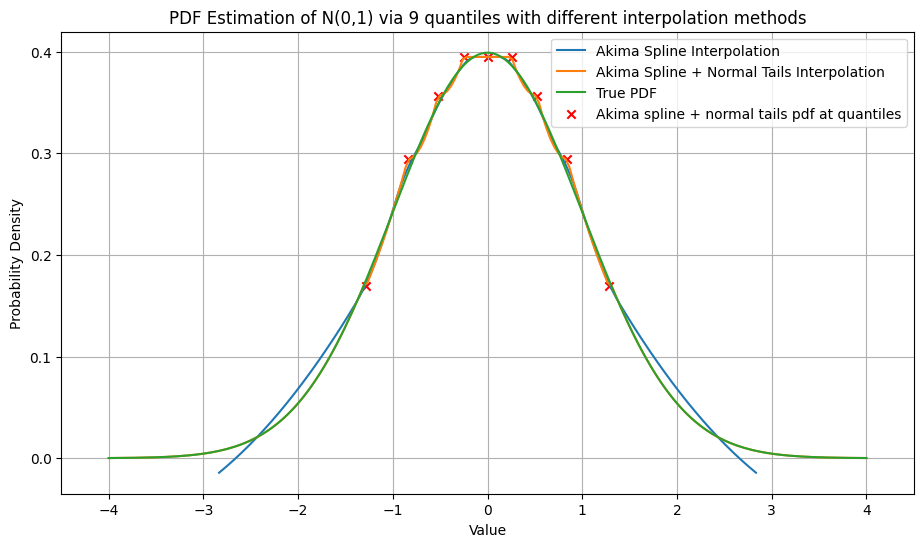

In [181]:
plot_cdf_pdf_dynamic(quantiles, probabilities, -3, 3, log_scale=False, case=3)

In [10]:
from scipy.integrate import quad

def evaluate(quantiles, probabilities, y, y_min, y_max):

    cdf_linear, cdf_pchip, hybrid_cdf, pdf_linear, pdf_linear2, pdf_pchip, pdf_hybrid = compute_cdf_pdf_interpolators(
        quantiles, probabilities, y_min, y_max
    )
    cdfs = [cdf_linear, cdf_pchip, hybrid_cdf]
    pdfs = [pdf_linear, pdf_linear2, pdf_pchip, pdf_hybrid]

    crps = []
    nlls = []

    for cdf in cdfs:
        integrand = lambda x: (cdf(x) - (x >= y))**2
        crps_value, _ = quad(integrand, y_min, y_max)
        crps.append(crps_value)

    for pdf in pdfs:
        pdf_value = pdf(y)
        negative_log_pdf = - np.log(pdf_value)
        nlls.append(negative_log_pdf)
    
    return (
        ('crps_cdf_linear', crps[0]),
        ('crps_cdf_pchip', crps[1]),
        ('crps_hybrid_cdf', crps[2]),
        ('nll_pdf_linear (eps = 0.01)', nlls[0]),
        ('nll_pdf_linear2 (eps = min_delta_quantile/2)', nlls[1]),
        ('nll_pdf_pchip', nlls[2]),
        ('nll_pdf_hybrid', nlls[3]),
    )
    

In [11]:
probabilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
quantiles = norm.ppf(probabilities)
y_min = -3
y_max = 3

evaluate(quantiles, probabilities, -2.5, y_min, y_max)

C:\Users\Manuel\AppData\Local\Temp\ipykernel_11188\862996740.py:16: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_value, _ = quad(integrand, y_min, y_max)


(('crps_cdf_linear', 1.8764192382545373),
 ('crps_cdf_pchip', 1.9508986356133764),
 ('crps_hybrid_cdf', 1.9401850423853335),
 ('nll_pdf_linear (eps = 0.01)', 2.8440069037156945),
 ('nll_pdf_linear2 (eps = min_delta_quantile/2)', 2.8440069037156697),
 ('nll_pdf_pchip', 4.252659642360903),
 ('nll_pdf_hybrid', 4.043938533204672))

In [12]:
y_min = -4
y_max = 4
evaluate(quantiles, probabilities, -2.5, y_min, y_max)

C:\Users\Manuel\AppData\Local\Temp\ipykernel_11188\862996740.py:16: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_value, _ = quad(integrand, y_min, y_max)


(('crps_cdf_linear', 1.8513057400122044),
 ('crps_cdf_pchip', 1.957475651969754),
 ('crps_hybrid_cdf', 1.9402651980596015),
 ('nll_pdf_linear (eps = 0.01)', 3.302646382036681),
 ('nll_pdf_linear2 (eps = min_delta_quantile/2)', 3.3026463820366674),
 ('nll_pdf_pchip', 3.217538091995092),
 ('nll_pdf_hybrid', 4.043938533204672))

In [17]:
import numpy as np
quantiles_2 = np.array([-3.302027, -2.657532, -2.326192, -2.163070, -1.983908, -1.761671, -1.496187, -1.286693, -1.028827])
quantiles_3 = np.array([-3.295995, -2.666942, -2.325560, -2.164748, -1.986944, -1.763564, -1.498355, -1.278293, -1.031841])
quantiles_4 = np.array([-3.289948, -2.672929, -2.321413, -2.163413, -1.990395, -1.773206, -1.510069, -1.285333, -1.042485])
probabilities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

evaluate(quantiles_4, probabilities, -1, y_min, y_max)

C:\Users\Manuel\AppData\Local\Temp\ipykernel_11188\862996740.py:16: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_value, _ = quad(integrand, y_min, y_max)


(('crps_cdf_linear', 0.6240623572361473),
 ('crps_cdf_pchip', 0.607558873439249),
 ('crps_hybrid_cdf', 0.608802841023876),
 ('nll_pdf_linear (eps = 0.01)', 3.920484109121023),
 ('nll_pdf_linear2 (eps = min_delta_quantile/2)', 2.203519999024279),
 ('nll_pdf_pchip', 0.9871778199039151),
 ('nll_pdf_hybrid', 1.2475395254789359))

# Cross check the crps and nll calculation based on a known distribution (normal)

In [ ]:
import pandas as pd
mu = 2
sigma = 1.5
y_min = mu - 7*sigma
y_max = mu + 7*sigma
probabilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
quantiles = norm.ppf(probabilities, loc=mu, scale=sigma)

y_values = [-4, -2, 0, 2, 4]

results_list = []

for y in y_values:
    z = (y - mu) / sigma
    crps_true = sigma * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi))
    nll_true = -norm.logpdf(y, scale=sigma, loc=mu)

    evaluate_results = evaluate(quantiles, probabilities, y, y_min, y_max)
    evaluate_dict = dict(evaluate_results)

    results_list.append({
        "y": y,
        "CRPS (Analytical)": crps_true,
        "CRPS (CDF Linear)": evaluate_dict["crps_cdf_linear"],
        "CRPS (CDF PCHIP, cubic interpolation)": evaluate_dict["crps_cdf_pchip"],
        "CRPS (Hybrid CDF)": evaluate_dict["crps_hybrid_cdf"],
        "NLL (Analytical)": nll_true,
        "NLL (PDF Linear, eps = 0.01)": evaluate_dict["nll_pdf_linear (eps = 0.01)"],
        "NLL (PDF Linear2, eps = min_delta_quantile/2)": evaluate_dict["nll_pdf_linear2 (eps = min_delta_quantile/2)"],
        "NLL (PDF PCHIP)": evaluate_dict["nll_pdf_pchip"],
        "NLL (PDF Hybrid)": evaluate_dict["nll_pdf_hybrid"]
    })

results = pd.DataFrame(results_list)

results.to_excel("../results/TabPFN/true_crps_nll_vs_interpolated.xlsx", index=False)



C:\Users\Manuel\AppData\Local\Temp\ipykernel_11188\862996740.py:16: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_value, _ = quad(integrand, y_min, y_max)
C:\Users\Manuel\AppData\Local\Temp\ipykernel_11188\862996740.py:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  crps_value, _ = quad(integrand, y_min, y_max)


# Old

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_cdf_pdf(quantiles, probabilities, y_min, y_max, log_scale=True, eps=0.01, tail=False):
    """Plots the CDF and PDF for linear, Akima1DInterpolator, and hybrid interpolation methods."""

    # Generate x values for plotting
    x_values = np.linspace(y_min - 1, y_max + 1, 200)

    # Get CDF and PDF functions
    cdf_linear, cdf_pchip, hybrid_cdf, pdf_linear, pdf_linear2, pdf_pchip, pdf_hybrid = compute_cdf_pdf_interpolators(
        quantiles, probabilities, y_min, y_max
    )

    y_min_shift = 1
    cdf_linear_m, cdf_pchip_m, hybrid_cdf_m, pdf_linear_m, pdf_linear2_m, pdf_pchip_m, pdf_hybrid_m = compute_cdf_pdf_interpolators(
    quantiles, probabilities, y_min - y_min_shift, y_max + y_min_shift
    )
    
    mu, sigma = fit_normal_dist_to_quantiles(probabilities, quantiles)


    # Compute CDF and PDF values
    cdf_values = {
        f"Linear Interpolation, y_min={y_min}": np.array([cdf_linear(x) for x in x_values]),
        f"Linear Interpolation, y_min={y_min - y_min_shift}": np.array([cdf_linear_m(x) for x in x_values]),
        "Akima Spline Interpolation": np.array([cdf_pchip(x) for x in x_values]),
        "Akima Spline + Normal Tails Interpolation": np.array([hybrid_cdf(x) for x in x_values]),
        "True CDF": norm.cdf(x_values)
    }
    # Vectorized evaluation of CDFs and PDFs
    #cdf_values_linear = np.array([cdf_linear(x) for x in x_values])
    #cdf_values_pchip = np.array([cdf_pchip(x) for x in x_values])
    #cdf_values_hybrid = np.array([hybrid_cdf(x) for x in x_values])
    #cdf_values_linear_m = np.array([cdf_linear_m(x) for x in x_values])


    selected_keys_temp = {
        f"Linear Interpolation": np.array([cdf_linear(x) for x in x_values]),
        "Akima Spline Interpolation": np.array([cdf_pchip(x) for x in x_values]),
        "True CDF": norm.cdf(x_values)
    }

    pdf_values = {
    f"Linear Interpolation epsilon=0.01, y_min={y_min}": np.array([pdf_linear(x) for x in x_values]),
    f"Linear Interpolation epsilon=0.01, y_min={y_min - y_min_shift}": np.array([pdf_linear_m(x) for x in x_values]),
    "Linear Interpolation epsilon=min_delta_quantile/2": np.array([pdf_linear2(x) for x in x_values]),
    "Akima Spline Interpolation": np.array([pdf_pchip(x) for x in x_values]),
    "Akima Spline + Normal Tails Interpolation": np.array([pdf_hybrid(x) for x in x_values]),
    "True PDF": norm.pdf(x_values, loc=mu, scale=sigma)
    }
    #pdf_values_linear = np.array([pdf_linear(x) for x in x_values])
    #pdf_values_linear2 = np.array([pdf_linear2(x) for x in x_values])
    #pdf_values_linear_m = np.array([pdf_linear_m(x) for x in x_values])
    #pdf_values_pchip = np.array([pdf_pchip(x) for x in x_values])
    #pdf_values_hybrid = np.array([pdf_hybrid(x) for x in x_values])


    # --- Plot CDFs ---
    plt.figure(figsize=(11, 6))
    #for label, values in cdf_values.items():
    #    plt.plot(x_values, values, label=label)
    #plt.scatter(quantiles, probabilities, color='y', marker='o', label="Quantiles")


    for label, values in selected_keys_temp.items():
        plt.plot(x_values, values, label=label)
    plt.scatter(quantiles, probabilities, color='y', marker='o', label="Quantiles")
    
    plt.xlabel("Value")
    plt.ylabel("Cumulative Probability")
    plt.title("CDF Estimation of N(0,1) via 9 quantiles with different interpolation methods")
    plt.legend()
    plt.grid(True)
    #plt.xlim(x_values[0], x_values[-1])
    plt.xlim(-1.5, 1.5)
    plt.show()


    # --- Plot PDFs ---
    # Define the keys you want to select
    selected_keys_tail = [
        f"Linear Interpolation epsilon=0.01, y_min={y_min}",
        f"Linear Interpolation epsilon=0.01, y_min={y_min - y_min_shift}",
        "Akima Spline Interpolation",
        "Akima Spline + Normal Tails Interpolation",
        "True PDF"
    ]

    selected_keys_not_tails = [
        f"Linear Interpolation epsilon=0.01",
        "Linear Interpolation epsilon=min_delta_quantile/2",
        "Akima Spline Interpolation",
    ]

    plt.figure(figsize=(11, 6))
    
    for label, values in pdf_values.items():
        if tail:
            if label in selected_keys_tail:  # Only plot these when tail is True
                if label in ("Akima Spline Interpolation", "Akima Spline + Normal Tails Interpolation"):
                    plt.plot(x_values, values, label=label, linestyle="-")
                else:
                    plt.plot(x_values, values, label=label, linestyle="--")
        else:
            plt.xlim(-1.5, 1.5)
            plt.ylim(0.10, 0.45)
            if label in selected_keys_not_tails:
                if label in ("Akima Spline Interpolation", "Akima Spline + Normal Tails Interpolation"):
                    plt.plot(x_values, values, label=label, linestyle="--", linewidth=1)
                else:
                    plt.plot(x_values, values, label=label, linestyle="--", linewidth=1)

    for label, values in selected_keys_not_tails.items():
        if tail:
            if label in selected_keys_tail:  # Only plot these when tail is True
                if label in ("Akima Spline Interpolation", "Akima Spline + Normal Tails Interpolation"):
                    plt.plot(x_values, values, label=label, linestyle="-")
                else:
                    plt.plot(x_values, values, label=label, linestyle="--")




    plt.scatter(quantiles, [pdf_pchip(q) for q in quantiles], color='r', marker='x', label="Akima Spline PDF at Quantiles")
    
    plt.xlabel("Value")
    plt.title("PDF Estimation of N(0,1) via 9 quantiles with different interpolation methods")
    #plt.legend(loc="upper left", fontsize=12, bbox_to_anchor=(1.15, 1.0))
    plt.legend(loc="lower center", fontsize=9)

    plt.grid(True)
    #plt.xlim(x_values[0], x_values[-1])
    
    if log_scale:
        plt.yscale("log")
        plt.ylim(1e-3, 1)
        plt.ylabel("Probability Density (log scale)")
    else:
        plt.ylabel("Probability Density")

    plt.show()


Probabilities: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Quantiles: [-1.28155157 -0.84162123 -0.52440051 -0.2533471   0.          0.2533471
  0.52440051  0.84162123  1.28155157]
Estimated Mean: -3.0819390988122016e-33, Estimated Std Dev: 1.0


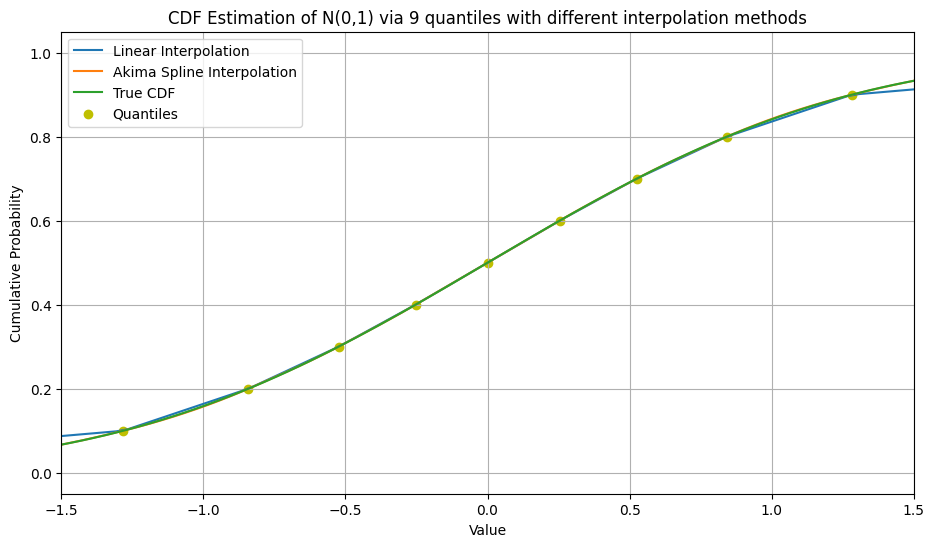

AttributeError: 'list' object has no attribute 'items'

<Figure size 1100x600 with 0 Axes>

In [105]:
#quantiles = np.array([-2.326, -1.960, -1.645, -1.282, 0, 1.282, 1.645, 1.960,2.326])
#probabilities = np.array([0.02, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.98])

probabilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
quantiles = norm.ppf(probabilities)

plot_cdf_pdf(quantiles, probabilities, y_min=-3, y_max=3, log_scale=False, tail=False)


## Test printout for selected value

In [130]:
# Example inputs
quantiles = np.array([-2.326, -1.960, -1.645, -1.282, 0, 1.282, 1.645, 1.960,2.326])
probabilities = np.array([0.02, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.98])

# Get all CDF and PDF functions
cdf_linear, cdf_pchip, hybrid_cdf, pdf_linear, pdf_linear2, pdf_pchip, pdf_hybrid = compute_cdf_pdf_interpolators(quantiles, probabilities)

# Choose an x value
x_value = 1.5

# Compute CDF values
print("Linear CDF at x =", x_value, ":", cdf_linear(x_value))
print("PCHIP CDF at x =", x_value, ":", cdf_pchip(x_value))
print("Hybrid CDF at x =", x_value, ":", hybrid_cdf(x_value))

# Compute PDF values
print("Linear PDF at x =", x_value, ":", pdf_linear(x_value))
print("PCHIP PDF at x =", x_value, ":", pdf_pchip(x_value))
print("Hybrid PDF at x =", x_value, ":", pdf_hybrid(x_value))



Linear CDF at x = 1.5 : 0.8600550964187328
PCHIP CDF at x = 1.5 : 0.860754147141796
Hybrid CDF at x = 1.5 : 0.860754147141796
Linear PDF at x = 1.5 : 0.27548209366391463
PCHIP PDF at x = 1.5 : 0.27813056930996277
Hybrid PDF at x = 1.5 : 0.293640606905417


## Test with quantiles given back by TabPFN

In [172]:
quantiles_2 = np.array([-3.302027, -2.657532, -2.326192, -2.163070, -1.983908, -1.761671, -1.496187, -1.286693, -1.028827])
quantiles_3 = np.array([-3.295995, -2.666942, -2.325560, -2.164748, -1.986944, -1.763564, -1.498355, -1.278293, -1.031841])
quantiles_4 = np.array([-3.289948, -2.672929, -2.321413, -2.163413, -1.990395, -1.773206, -1.510069, -1.285333, -1.042485])
probabilities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [49]:
#plot_cdf_pdf(quantiles_2, probabilities, -25, 2, log_scale=False, tail=True)

NameError: name 'quantiles_2' is not defined

In [161]:
from scipy.optimize import curve_fit

# Define a function that maps probabilities to normal quantiles
def normal_cdf_inverse(p, mu, sigma):
    return norm.ppf(p, loc=mu, scale=sigma)

# Fit the normal distribution
params, _ = curve_fit(normal_cdf_inverse, probabilities, quantiles_2, p0=[0, 1])  # Initial guess: mean=0, std=1

mu_fit, sigma_fit = params
print(f"Estimated Mean: {mu_fit}, Estimated Std Dev: {sigma_fit}")

Estimated Mean: -2.0006785552168824, Estimated Std Dev: 0.8557809665149574
